In [13]:
# ================================
# 1. Imports
# ================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [14]:
frame = cv2.imread('out.jpg')

In [15]:
# # path ของวิดีโอ
# input_video = "test_on_lab_0001.mp4"   # <-- เปลี่ยน path เป็นไฟล์วิดีโอของคุณ
# selected_frame = 2000       # <-- เปลี่ยนหมายเลขเฟรมที่ต้องการดึง

# cap = cv2.VideoCapture(input_video)
# if not cap.isOpened():
#     raise RuntimeError("ไม่สามารถเปิดวิดีโอได้")

# # จำนวนเฟรมทั้งหมด
# total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# print(f"📹 วิดีโอนี้มีทั้งหมด {total_frames} เฟรม")

# # ตรวจสอบว่าเลขเฟรมอยู่ในช่วง
# if selected_frame >= total_frames:
#     raise ValueError(f"เลขเฟรม {selected_frame} เกินจำนวนเฟรมสูงสุด {total_frames-1}")

# # กระโดดไปที่เฟรมที่เลือก
# cap.set(cv2.CAP_PROP_POS_FRAMES, selected_frame)
# ret, frame = cap.read()

# if not ret:
#     raise RuntimeError(f"❌ อ่านเฟรม {selected_frame} ไม่ได้")

# cap.release()
# cv2.imwrite("out.jpg", frame)

# # ตอนนี้ frame คือภาพจากวิดีโอที่เลือก
# # frame จะอยู่ในรูปแบบ numpy array (BGR)

# # แสดงเฟรมที่ดึงมาจากวิดีโอ
# plt.figure(figsize=(12, 8))
# plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
# plt.title(f"Frame {selected_frame} from video: {input_video}")
# plt.axis('off')
# plt.show()

# print(f"✅ แสดงเฟรมที่ {selected_frame} จากวิดีโอ {input_video}")
# print(f"📏 ขนาดภาพ: {frame.shape[1]}x{frame.shape[0]} pixels")

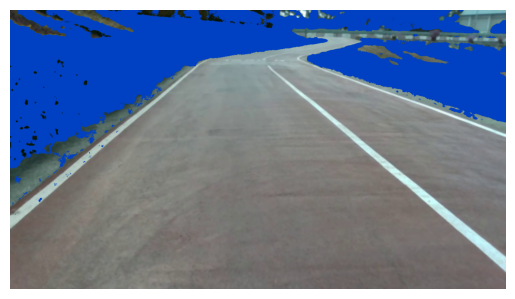

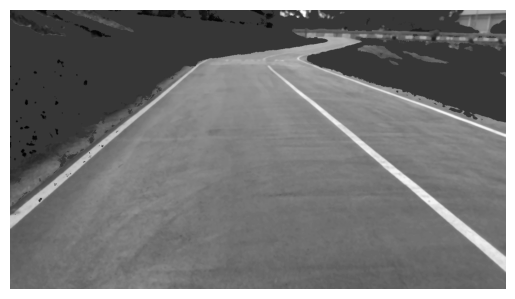

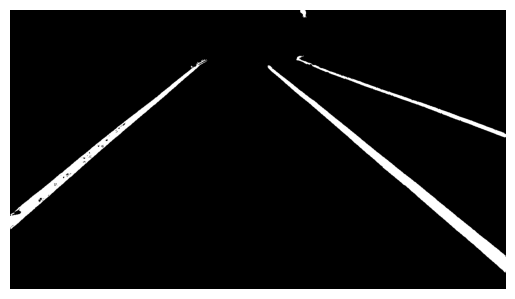

In [16]:
# gaussian blur & median filter ภาพก่อนประมวลผล
frame = cv2.GaussianBlur(frame, (5, 5), 0)
frame = cv2.medianBlur(frame, 5)


# แปลงภาพเป็น LAB (จาก frame ที่อ่านมาจากวิดีโอ)
lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
L = lab[:, :, 0]
A = lab[:, :, 1]
B = lab[:, :, 2]

# สร้าง mask สีเขียว (A ต่ำ, B สูง)
green_mask = np.zeros_like(A, dtype=np.uint8)
green_mask[(A < 120) & (B > 130)] = 1

# สร้าง mask สีแดง (A สูง, B ต่ำ~กลาง)
red_mask = np.zeros_like(A, dtype=np.uint8)
red_mask[(A > 140) & (B < 140)] = 1

# เอาสีเขียวออก เหลือเฉพาะพื้นที่สีแดง
lab_no_green = lab.copy()
lab_no_green[green_mask == 1] = 0


# แสดงภาพผลลัพธ์จากขั้นตอนก่อนหน้า
plt.imshow(cv2.cvtColor(lab_no_green, cv2.COLOR_LAB2RGB))
plt.axis('off')
plt.show()


# แปลงกลับเป็น RGB เพื่อทำ gradient
img_rgb_no_green = cv2.cvtColor(lab_no_green, cv2.COLOR_LAB2RGB)
gray = cv2.cvtColor(img_rgb_no_green, cv2.COLOR_RGB2GRAY)

# แสดงภาพผลลัพธ์ gray
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.show()

# Sobel x, y
abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3))
abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3))
gradx = np.zeros_like(gray, dtype=np.uint8)
grady = np.zeros_like(gray, dtype=np.uint8)
gradx[(abs_sobel_x >= 50) & (abs_sobel_x <= 100)] = 1
grady[(abs_sobel_y >= 50) & (abs_sobel_y <= 100)] = 1

# Magnitude
mag = np.sqrt(abs_sobel_x**2 + abs_sobel_y**2)
mag = (mag / (np.max(mag)/255.0 + 1e-6)).astype(np.uint8)
mag_binary = np.zeros_like(mag)
mag_binary[(mag >= 30) & (mag <= 100)] = 1


# Direction
dir_binary = np.zeros_like(gray)
absgraddir = np.arctan2(abs_sobel_y, abs_sobel_x + 1e-9)
dir_binary[(absgraddir >= 0.7) & (absgraddir <= 1.3)] = 1


# White pixel (เน้นเส้นสีขาว)
white_binary = np.zeros_like(gray, dtype=np.uint8)
white_binary[gray > 180] = 1

# Combined
combined = np.zeros_like(gray, dtype=np.uint8)
combined[((gradx == 1) & (grady == 1)) |
         ((mag_binary == 1) & (dir_binary == 1)) |
         (white_binary == 1)] = 1

# ทำ coutour เอาพื้นที่ที่ pixel น้อยๆในรูป ออก
contours, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    if cv2.contourArea(cnt) < 100:  # กำหนดขนาดพื้นที่ขั้นต่ำ
        cv2.drawContours(combined, [cnt], 0, 0, -1)
        
# แสดงผลลัพธ์
plt.imshow(combined, cmap='gray')
plt.axis('off')
plt.show()


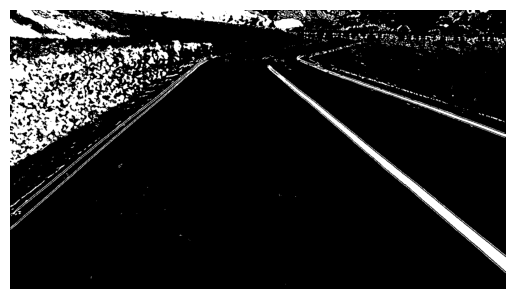

In [17]:
# แปลงภาพเป็น RGB (จาก frame ที่อ่านมาจากวิดีโอ)
img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# ---------------- abs_sobel_thresh (x, y) ----------------
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# x-gradient
abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3))
denom_x = np.max(abs_sobel_x) if np.max(abs_sobel_x) > 0 else 1.0
scaled_x = np.uint8(255 * abs_sobel_x / denom_x)
gradx = np.zeros_like(scaled_x, dtype=np.uint8)
gradx[(scaled_x >= 20) & (scaled_x <= 100)] = 1

# y-gradient
abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3))
denom_y = np.max(abs_sobel_y) if np.max(abs_sobel_y) > 0 else 1.0
scaled_y = np.uint8(255 * abs_sobel_y / denom_y)
grady = np.zeros_like(scaled_y, dtype=np.uint8)
grady[(scaled_y >= 20) & (scaled_y <= 100)] = 1

# ---------------- magnitude threshold ----------------
sx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
mag = np.sqrt(sx**2 + sy**2)
denom_mag = (np.max(mag) / 255.0) if np.max(mag) > 0 else 1.0
mag_scaled = (mag / denom_mag).astype(np.uint8)
mag_binary = np.zeros_like(mag_scaled, dtype=np.uint8)
mag_binary[(mag_scaled >= 30) & (mag_scaled <= 100)] = 1

# ---------------- direction threshold ----------------
absgraddir = np.arctan2(np.absolute(sy), np.absolute(sx) + 1e-9)
dir_binary = np.zeros_like(gray, dtype=np.uint8)
dir_binary[(absgraddir >= 0.7) & (absgraddir <= 1.3)] = 1

# ---------------- HLS S-channel threshold ----------------
hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
s = hls[:, :, 2]
hls_binary = np.zeros_like(s, dtype=np.uint8)
hls_binary[(s > 90) & (s <= 255)] = 1

# ---------------- White pixel threshold ----------------
white_binary = np.zeros_like(gray, dtype=np.uint8)
white_binary[gray > 200] = 1

# ---------------- Combined ----------------
combined = np.zeros_like(dir_binary, dtype=np.uint8)
combined[((gradx == 1) & (grady == 1)) |
         ((mag_binary == 1) & (dir_binary == 1)) |
         (hls_binary == 1) |
         (white_binary == 1)] = 1

# แสดงผล
plt.imshow(combined, cmap='gray')
plt.axis('off')
plt.show()


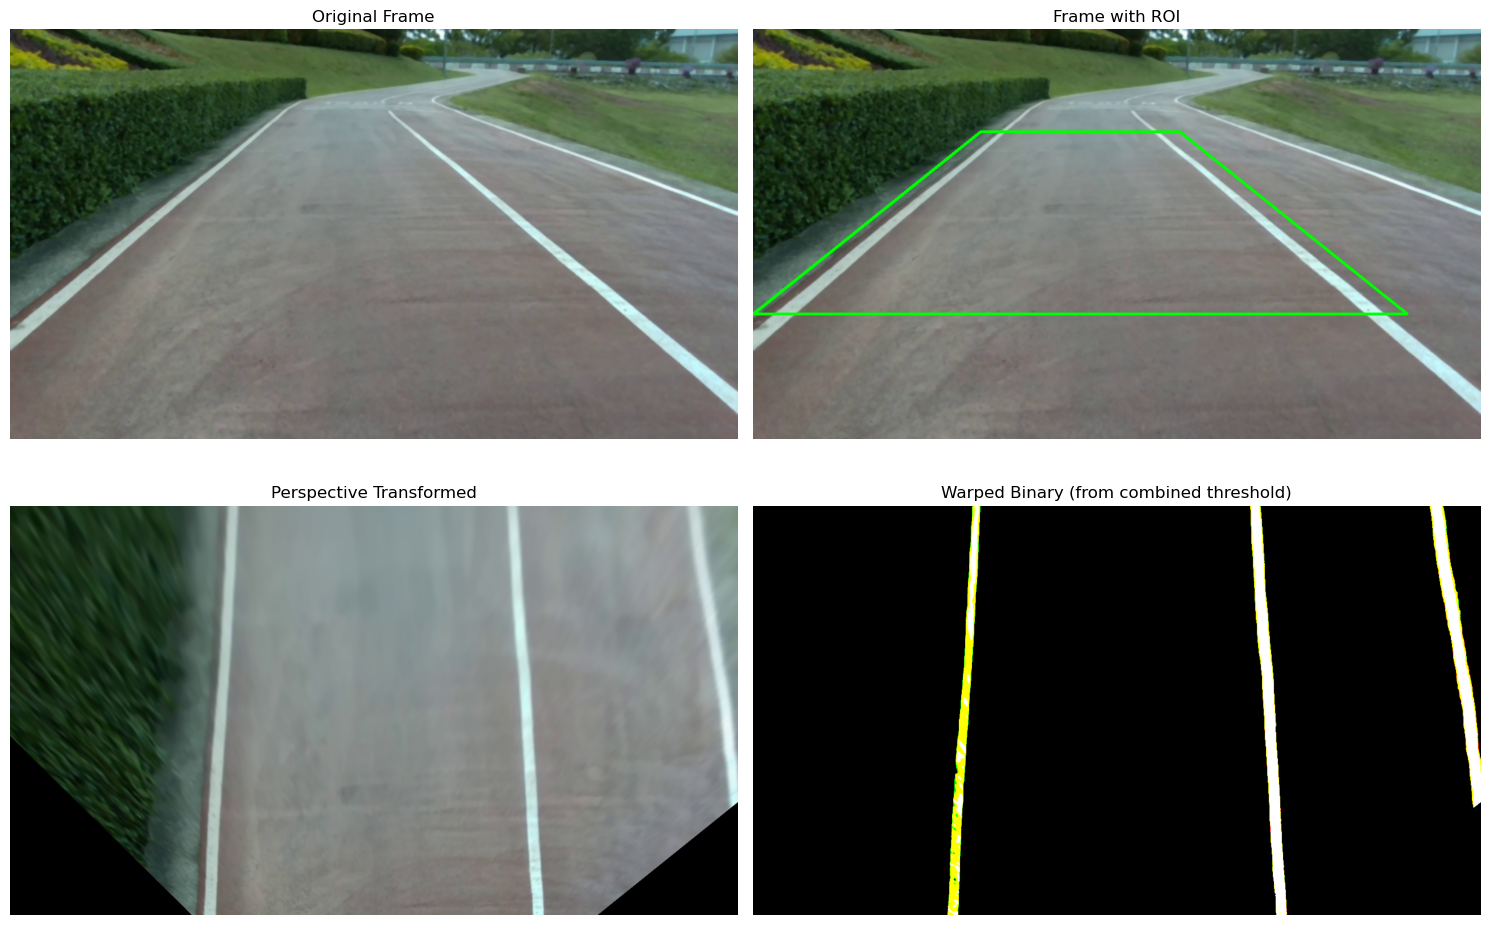

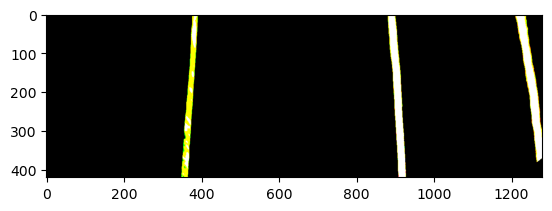

In [18]:
# ================================
# 3. Perspective Transform Helpers (No Functions)
# ================================

# สมมติ frame มีขนาด
frame_h, frame_w = frame.shape[:2]

# ROI base (จุดต้นแบบจากภาพขนาด 1280x720)
ROI_BASE = np.float32([[0, 500],[1150, 500],[750, 180],[400, 180]])

# -------- get_roi_points_scaled --------
base_w, base_h = 1280, 720
sx = frame_w / float(base_w)
sy = frame_h / float(base_h)

roi_points = np.float32([[p[0]*sx, p[1]*sy] for p in ROI_BASE])
# print(f"result from section 3 : {roi_points}")

# -------- simple_roi_matrices --------
dst_left, dst_right, dst_top, dst_bottom = 0.25, 0.75, 0.0, 1.0

dst = np.float32([
    [frame_w * dst_left,  frame_h * dst_bottom],
    [frame_w * dst_right, frame_h * dst_bottom],
    [frame_w * dst_right, frame_h * dst_top],
    [frame_w * dst_left,  frame_h * dst_top]
])

M    = cv2.getPerspectiveTransform(roi_points, dst)
Minv = cv2.getPerspectiveTransform(dst, roi_points)

# -------- perspective_transform --------
binary_warped = cv2.warpPerspective(frame, M, (frame_w, frame_h))

# -------- Visualize ROI on original frame --------
plt.figure(figsize=(15, 10))

# แสดงภาพต้นฉบับ
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title('Original Frame')
plt.axis('off')

# วาด ROI บนภาพต้นฉบับ
frame_with_roi = frame.copy()
roi_pts = roi_points.astype(np.int32)
cv2.polylines(frame_with_roi, [roi_pts], True, (0, 255, 0), 3)

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(frame_with_roi, cv2.COLOR_BGR2RGB))
plt.title('Frame with ROI')
plt.axis('off')

# แสดงภาพหลัง perspective transform
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(binary_warped, cv2.COLOR_BGR2RGB))
plt.title('Perspective Transformed')
plt.axis('off')

# ถ้าอยาก ensure ว่าเป็น binary 0/255
_, warped_combined = cv2.threshold(binary_warped, 180, 255, cv2.THRESH_BINARY)

plt.subplot(2, 2, 4)
plt.imshow(warped_combined, cmap='gray')
plt.title('Warped Binary (from combined threshold)')
plt.axis('off')

plt.tight_layout()
plt.show()

H, W = warped_combined.shape[:2]
warped_combined = warped_combined[150:H-150, :]
plt.imshow(warped_combined, cmap='gray')

TypeError: Invalid shape (420, 1280, 9) for image data

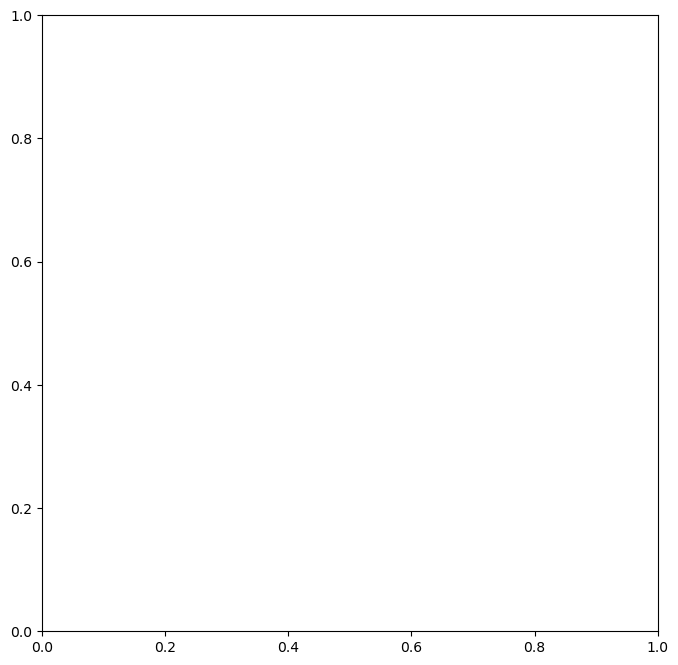

In [ ]:
# ================================
# 4. Lane Finding Functions (Left -+ Right)
# ================================
def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=50):
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    out_img = np.dstack([binary_warped, binary_warped, binary_warped]) * 255
    midpoint = histogram.shape[0] // 2
    leftx_base  = int(np.argmax(histogram[:midpoint]))
    rightx_base = int(np.argmax(histogram[midpoint:]) + midpoint)
    window_height = binary_warped.shape[0] // nwindows

    nonzero  = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current, rightx_current = leftx_base, rightx_base
    left_lane_inds, right_lane_inds = [], []

    for window in range(nwindows):
        win_y_low  = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height

        # ซ้าย
        win_xleft_low  = leftx_current - margin
        win_xleft_high = leftx_current + margin
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))

        # ขวา
        win_xright_low  = rightx_current - margin
        win_xright_high = rightx_current + margin
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        right_lane_inds.append(good_right_inds)
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds  = np.concatenate(left_lane_inds) if len(left_lane_inds) else np.array([], dtype=int)
    right_lane_inds = np.concatenate(right_lane_inds) if len(right_lane_inds) else np.array([], dtype=int)

    leftx, lefty   = nonzerox[left_lane_inds], nonzeroy[left_lane_inds]
    rightx, righty = nonzerox[right_lane_inds], nonzeroy[right_lane_inds]

    if leftx.size > 0:
        out_img[lefty, leftx] = [255, 0, 0]   # สีแดงสำหรับซ้าย
    if rightx.size > 0:
        out_img[righty, rightx] = [0, 0, 255] # สีน้ำเงินสำหรับขวา

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, spacing_px=30, nwindows=9, margin=100, minpix=50):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, nwindows, margin, minpix)

    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])

    left_fitx, right_fitx = None, None
    left_fit, right_fit = None, None
    pts_left, pts_right = [], []

    detected_left, detected_right = False, False

    if leftx.size >= 50:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        y_idx = np.arange(0, len(ploty), spacing_px, dtype=int)
        pts_left = [(int(left_fitx[i]), int(ploty[i])) for i in y_idx
                    if 0 <= left_fitx[i] < binary_warped.shape[1]]
        for (x, y) in pts_left:
            cv2.circle(out_img, (x, y), 5, (255, 255, 0), -1)
        detected_left = True

    if rightx.size >= 50:
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        y_idx = np.arange(0, len(ploty), spacing_px, dtype=int)
        pts_right = [(int(right_fitx[i]), int(ploty[i])) for i in y_idx
                     if 0 <= right_fitx[i] < binary_warped.shape[1]]
        for (x, y) in pts_right:
            cv2.circle(out_img, (x, y), 5, (0, 255, 255), -1)
        detected_right = True

    return {
        'left_fit': left_fit, 'right_fit': right_fit,
        'ploty': ploty,
        'left_fitx': left_fitx, 'right_fitx': right_fitx,
        'points_left': pts_left, 'points_right': pts_right,
        'detected_left': detected_left, 'detected_right': detected_right,
        'vis': out_img
    }



# ----------------- Run -----------------
fit_data = fit_polynomial(warped_combined)

# Display results
plt.figure(figsize=(15, 8))
plt.imshow(fit_data['vis'])
if fit_data['left_fitx'] is not None:
    plt.plot(fit_data['left_fitx'], fit_data['ploty'], color='yellow', linewidth=2)
if fit_data['right_fitx'] is not None:
    plt.plot(fit_data['right_fitx'], fit_data['ploty'], color='cyan', linewidth=2)
plt.title('Left & Right Lanes (Polynomial Fit)')
plt.axis('off')
plt.show()

print(f"Left lane detected:  {fit_data['left_fit'] is not None}")
print(f"Right lane detected: {fit_data['right_fit'] is not None}")


In [ ]:
# ---------- draw_lane ----------
warp_zero = np.zeros_like(warped_combined).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

if fit_data['detected_left'] and fit_data['detected_right']:
    pts_left  = np.array([np.transpose(np.vstack((fit_data['left_fitx'],  fit_data['ploty'])))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack((fit_data['right_fitx'], fit_data['ploty']))))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int32([pts]), (0, 255, 0))

h, w = frame.shape[:2]
newwarp = cv2.warpPerspective(color_warp, Minv, (w, h))
drawn_result = cv2.addWeighted(frame, 1.0, newwarp, 0.3, 0)

# ---------- fit line ซ้าย ----------
m_left, b_left = np.nan, np.nan
if fit_data['detected_left']:
    ys_left = np.array([p[1] for p in fit_data['points_left']], dtype=np.float64)
    xs_left = np.array([p[0] for p in fit_data['points_left']], dtype=np.float64)
    m_left, b_left = np.polyfit(ys_left, xs_left, 1)

# ---------- fit line ขวา ----------
angle_signed_deg, m_right, b_right = np.nan, np.nan, np.nan
img_vis = (np.dstack([warped_combined, warped_combined, warped_combined]) * 255).astype(np.uint8)

if fit_data['detected_right']:
    ys_right = np.array([p[1] for p in fit_data['points_right']], dtype=np.float64)
    xs_right = np.array([p[0] for p in fit_data['points_right']], dtype=np.float64)
    m_right, b_right = np.polyfit(ys_right, xs_right, 1)
    angle_signed_deg = np.degrees(np.arctan(m_right))

    # วาดเส้น
    y0, y1 = 0, warped_combined.shape[0]-1
    cv2.line(img_vis, (int(m_right*y0+b_right), y0), (int(m_right*y1+b_right), y1), (0,255,0), 3)
    if fit_data['detected_left']:
        cv2.line(img_vis, (int(m_left*y0+b_left), y0), (int(m_left*y1+b_left), y1), (255,0,0), 3)


In [ ]:
# ================================
# 6. Per-frame Pipeline (No Functions, Left+Right, with print)
# ================================

fit_data = fit_polynomial(warped_combined)

lane_params = {
    "left":  {"m": np.nan, "b": np.nan, "angle": np.nan, "detected": fit_data['detected_left']},
    "right": {"m": np.nan, "b": np.nan, "angle": np.nan, "detected": fit_data['detected_right']}
}

H, W = warped_combined.shape[:2]

# ---- LEFT ----
if fit_data['detected_left']:
    ys = np.array([p[1] for p in fit_data['points_left']], dtype=np.float64)
    xs = np.array([p[0] for p in fit_data['points_left']], dtype=np.float64)
    m, b = np.polyfit(ys, xs, 1)
    lane_params["left"].update({"m": m, "b": b - (W//2), "angle": np.degrees(np.arctan(m))})

# ---- RIGHT ----
if fit_data['detected_right']:
    ys = np.array([p[1] for p in fit_data['points_right']], dtype=np.float64)
    xs = np.array([p[0] for p in fit_data['points_right']], dtype=np.float64)
    m, b = np.polyfit(ys, xs, 1)
    lane_params["right"].update({"m": m, "b": b - (W//2), "angle": np.degrees(np.arctan(m))})

# ---- PRINT RESULTS ----
print('---------------------------------')
print("Lane detection results:")

if lane_params["left"]["detected"]:
    print(f"✅ Left lane  detected | m={lane_params['left']['m']:.6f}, b={lane_params['left']['b']:.6f}, angle={lane_params['left']['angle']:.3f}°")
else:
    print("❌ Left lane  not detected")

if lane_params["right"]["detected"]:
    print(f"✅ Right lane detected | m={lane_params['right']['m']:.6f}, b={lane_params['right']['b']:.6f}, angle={lane_params['right']['angle']:.3f}°")
else:
    print("❌ Right lane not detected")

# ค่าเฉลี่ย ถ้า detect ได้ทั้งสอง
if lane_params["left"]["detected"] and lane_params["right"]["detected"]:
    avg_m = (lane_params["left"]["m"] + lane_params["right"]["m"]) / 2.0
    avg_b = (lane_params["left"]["b"] + lane_params["right"]["b"]) / 2.0
    avg_angle = (lane_params["left"]["angle"] + lane_params["right"]["angle"]) / 2.0
    print(f"📐 Average lane | m={avg_m:.6f}, b={avg_b:.6f}, angle={avg_angle:.3f}°")
else:
    print("📐 Average lane : N/A (one or both missing)")


---------------------------------
Lane detection results:
✅ Left lane  detected | m=-0.061116, b=-247.373333, angle=-3.497°
✅ Right lane detected | m=0.065101, b=242.123333, angle=3.725°
📐 Average lane | m=0.001993, b=-2.625000, angle=0.114°
